In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import scipy.special as sp
from scipy.optimize import curve_fit
import slmsuite.holography.toolbox as toolbox

In [24]:
# Python implementation of the Nelder-Mead algorithm

def nelder_mead(f, initial_point, initial_step, tolerance, maxiter, alpha, gamma, rho, sigma):
    
    # Dimension of vector space
    dim = len(initial_point)

    # Create the initial simplex

    # Add initial point and its loss value
    current_simplex = [[initial_point, f(initial_point)]]
    # Add initial step to each dimension of initial point
    for i in range(dim):
        initial_point_copy = np.copy(initial_point)
        initial_point_copy[i] = initial_point_copy[i] + initial_step
        current_simplex.append([initial_point_copy, f(initial_point_copy)])
    
    print(current_simplex)
    
    iter = 0

    while True:
        
        iter += 1
        print(iter)

        # Order the points by loss value
        ordered_simplex = sorted(current_simplex, key=lambda x: float(x[1]))

        # Display best and worst points
        #print(ordered_simplex)
        print(ordered_simplex[0])
        print(ordered_simplex[-1])

        # Check for termination
        # For now terminate when reached max # of iterations
        if iter == maxiter:
            # Return the simplex
            return ordered_simplex
        
        else:

            # Calculate centroid
            centroid_point = centroid(ordered_simplex[:-1])

            # Calculate reflected point
            worst_point = ordered_simplex[-1][0]
            reflected_point = reflected(centroid_point, alpha, worst_point)
            reflected_point_value = f(reflected_point)

            # Get value of best and 2nd worst points
            best_point_value = ordered_simplex[0][1]
            second_worst_point_value = ordered_simplex[-2][1]
            
            if best_point_value <= reflected_point_value < second_worst_point_value:

                # Replace worst point with reflected
                ordered_simplex.pop()
                ordered_simplex.append([reflected_point, reflected_point_value])
                current_simplex = ordered_simplex
                print('Swapped worst with reflected')
                continue

            elif reflected_point_value < best_point_value:

                # Calculate expanded point
                expanded_point = expanded(centroid_point, gamma, reflected_point)
                expanded_point_value = f(expanded_point)

                if expanded_point_value < reflected_point_value:

                    # Replace worst point with expanded
                    ordered_simplex.pop()
                    ordered_simplex.append([expanded_point, expanded_point_value])
                    current_simplex = ordered_simplex
                    print('Swapped worst with expanded')
                    continue

                else:

                    # Replace worst point with reflected
                    ordered_simplex.pop()
                    ordered_simplex.append([reflected_point, reflected_point_value])
                    current_simplex = ordered_simplex
                    print('Swapped worst with reflected')
                    continue

            else:

                # Get worst point value
                worst_point_value = ordered_simplex[-1][1]

                if reflected_point_value < worst_point_value:

                    # Calculate outside contracted point
                    contracted_point = contraction_outside(centroid_point, rho, reflected_point)
                    contracted_point_value = f(contracted_point)

                    if contracted_point_value < reflected_point_value:

                        # Replace worst point with outside contracted
                        ordered_simplex.pop()
                        ordered_simplex.append([contracted_point, contracted_point_value])
                        current_simplex = ordered_simplex
                        print('Swapped worst with outside contracted')
                        continue

                    else:

                        # Shrink simplex, replace all but the best point with shrunk points
                        current_simplex = shrink(ordered_simplex, sigma, f)
                        print("Shrunk points")
                        continue
                        
                elif reflected_point_value >= worst_point_value:

                    # Calculate inside contracted point
                    contracted_point = contraction_inside(centroid_point, rho, worst_point)
                    contracted_point_value = f(contracted_point)

                    if contracted_point_value < worst_point_value:

                        # Replace worst point with inside contracted
                        ordered_simplex.pop()
                        ordered_simplex.append([contracted_point, contracted_point_value])
                        current_simplex = ordered_simplex
                        print('Swapped worst with inside contracted')
                        continue

                    else:

                        # Shrink simplex, replace all but the best point with shrunk points
                        current_simplex = shrink(ordered_simplex, sigma, f)
                        print('Shrunk points')
                        continue

# Calculate the centroid of the simplex
def centroid(simplex):

    # # of points in simplex
    num_points = len(simplex)

    # Dimension of points
    dim_points = len(simplex[0][0])

    # Sum points in simplex
    point_sum = np.zeros(dim_points)
    for p in simplex:
        point_sum = point_sum + p[0]

    # Return centroid point
    return point_sum / num_points

# Calculate reflected point
def reflected(centroid, alpha, worst_point):
    return centroid + alpha * (centroid - worst_point)

# Calculate expanded point
def expanded(centroid, gamma, reflected):
    return centroid + gamma * (reflected - centroid)

# Calculate outside contracted point
def contraction_outside(centroid, rho, reflected):
    return centroid + rho * (reflected - centroid)

# Calculate inside contracted point
def contraction_inside(centroid, rho, worst):
    return centroid + rho * (worst - centroid)

# Shrink simplex
def shrink(simplex, sigma, f):

    # Get best point
    best_point = simplex[0][0]

    # Replace other points with shrunk points and their loss value
    for p in simplex[1:]:
        p[0] = best_point + sigma * (p[0] - best_point)
        p[1] = f(p[0])

    return simplex

# Termination
def termination(simplex):
    return 1

In [18]:
# Functions to fit a point to a 2D Gaussian

# Gaussian
def gaussian(x, a, w):
    return a*np.exp(-2*x**2/w**2)

# Shifted Gaussian
def gaussian_sh(x, a, w, x0):
    return a*np.exp(-2*(x-x0)**2/w**2)

# 2D Gaussian
def gaussian2D(X, a, wx, x0, wy, y0):
    x, y = X
    g =  a*np.exp((-2 * ((x-x0)**2/wx**2)) + (-2 * ((y-y0)**2/wy**2)))
    return g.ravel()

# New function for 2D plotting:
# only works for square images
# note to convert between length_arr = larr to pixelnum:
# (M/pixsize)*larr + shift = pixnum
def splot2(axis=None, img=None, xaxis=True, plot=False):
    data = img[:, 0] # to use len(data)
    pixelnum = np.arange(0, len(data))
    pns = pixelnum # pixelnum no shift
    shift =  len(data)/2
    pixelnum = pixelnum-shift
    # Shift to actual length scale.
    pixelsize = 3.450 # um
    magnification = 1
    actual_length = pixelsize/magnification # in um
    larr = actual_length*pixelnum

    xm, ym = np.meshgrid(larr, larr)

    #print(img.shape) --> don't forget img has 3 color chanels
    #print(img.ravel().shape)
    #print(xm.shape)

    # Also plot the theoretical on-axis PSF
    popt, pcov = curve_fit(gaussian2D, (xm, ym), img[:, :].ravel())

    # Calculate r-squared of the fit
    residuals = img[:, :].ravel() - gaussian2D((xm, ym), *popt)
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((img[:, :].ravel() - np.mean(img[:, :].ravel())) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Plot the fit
    if plot is True:
        xfit = np.linspace(larr[0], larr[-1], 2000)
        axis.plot(xfit, gaussian_sh(xfit, popt[0], popt[1], popt[2]), label="x-axis fit, wx = "+str(np.round(popt[1], 2))+"um", ls="--", c="g")
        axis.plot(xfit, gaussian_sh(xfit, popt[0], popt[3], popt[4]), label="y-axis fit, wy = "+str(np.round(popt[3], 2))+"um", ls="--", c="r")

    return larr, popt, pcov, [magnification, pixelsize, shift], r_squared

def plot_final_array(img, params, plot=False):
    x1, length, y1, height, box_size = params[0], params[1], params[2], params[3], params[4]
    # Final extraction:
    norm = img[y1:y1+height, x1:x1+length]

    if plot is False:
    
        larr, popt, pcov, tra, r_squared = splot2(axis=None, img=norm, plot=plot)
    
    elif plot is True:

        # Plot extraction
        fig = plt.figure(figsize=(10,5))

        # Make subplots
        ax00 = fig.add_subplot(1,2,1)
        ax01 = fig.add_subplot(1,2,2)

        larr, popt, pcov, tra, r_squared = splot2(axis=ax00, img=norm, plot=plot)

        # Get the fitted center positions
        xc = popt[2]
        yc = popt[4]

        # Unpack transformation parameters
        M = tra[0]
        ps = tra[1]
        shift = tra[2]    

        # Convert back to camera coordinates
        xc = (M/ps)*xc + shift
        yc = (M/ps)*yc + shift

        # Convert center positions to pixels via rounding
        xc = int(np.round(xc))
        yc = int(np.round(yc))

        #print(xc, yc)
        norm = norm[:, :] # select only one color channel
        xdata = norm[yc, :]
        ydata = norm[:, xc]
        
        ax00.scatter(larr, xdata, c = "g", s=5)
        ax00.scatter(larr, ydata, c = "r", s=5)

        #ax01.legend()
        ax00.legend()

        # Show image
        ax01.imshow(norm)
        ax01.axvline(xc, c="red")     # x-axis
        ax01.axhline(yc, c="green")   # y-axis

        fig.tight_layout()

        plt.subplots_adjust(top=0.92)

    return norm, larr, popt, pcov, r_squared # Return first color channel of norm

In [19]:
# Function to fit all spots in the array

def fit_array(box_size, shiftx, shifty, img, hologram, plot=False):

    # List of fit parameter arrays
    popt_arrays = []
    # List of covariance matrices
    pcov_arrays = []
    # List of waist residuals
    waist_residuals = []
    # List of r-squared
    r_squared_values = []
    
    # Spot coordinates
    spot_coords = hologram.spot_ij
    x_coords = spot_coords[0]
    y_coords = spot_coords[1]
    # Change coord format to (x,y)
    spot_coords = np.concatenate([x_coords[:,None], y_coords[:,None]], axis=1)

    # Iterate over spots in the array
    for p in spot_coords:
        
        # Crop the camera image
        cropx, x_len, cropy, y_len = 0, 1000, 0, 1000
        img_cropped = img[cropy:cropy+y_len, cropx:cropx+x_len]

        # Create a box around the spot coordinates
        x1 = p[0] - cropx - int(box_size/2) + shiftx # leftmost coord
        y1 = p[1] - cropy - int(box_size/2) + shifty # topmost coord
        length = box_size
        height = box_size

        # Save the box parameters
        params = [x1, length, y1, height, box_size]

        # Fit the content of the box to a 2D Gaussian
        norm, larr, popt, pcov, r_squared = plot_final_array(img_cropped, params)

        # Calculate error of the waist ratio
        wx = popt[1]
        wy = popt[3]
        waist_ratio = wx/wy
        wr_error = np.abs(waist_ratio - 1)

        # Add fit statistics to the lists
        popt_arrays.append(popt)
        pcov_arrays.append(pcov)
        waist_residuals.append(wr_error)
        r_squared_values.append(r_squared)

        if plot is True:

            fig0,ax0 = plt.subplots(1, 2, figsize=(16,6))

            # Display original image
            ax0[0].imshow(img)
            ax0[0].set_title("Original Image")

            # Create rectangle for the box
            rect1 = patches.Rectangle((x1, y1), length, height, linewidth=1, edgecolor="cyan", facecolor="none")

            # Add box to the cropped image
            ax0[1].add_patch(rect1)
            ax0[1].text(x1, y1-2,'Sample', c="cyan")

            # Display cropped image
            ax0[1].imshow(img_cropped)
            ax0[1].set_title("(Non-normalized) Cropped Image")

            # Also add the rectangle to the original image
            rect_corrected = patches.Rectangle((x1+cropx, y1+cropy), length, height, linewidth=1, edgecolor="cyan", facecolor="none")
            ax0[0].add_patch(rect_corrected)

    return popt_arrays, r_squared_values, waist_residuals

In [20]:
# Function to collect and display fit statistics

def fit_stats(popt_arrays, plot=False):
    
    # List of waists in x and y
    wxs = []
    wys = []
    # List of amplitudes
    a_arr = []

    # Iterate over fit parameters for all the spots
    for popt in popt_arrays:
        # Extract waist in x and y
        a_arr.append(popt[0])
        wxs.append(popt[1])
        # Extract amplitude
        wys.append(popt[3])

    # Convert lists to arrays
    wxs = np.array(wxs)
    wys = np.array(wys)
    a_arr = np.array(a_arr)

    if plot is True:

        # Plot Histograms
        hfig, hax = plt.subplots(1, 5, figsize=(20,5))
        plt.suptitle("Full Array Fit Statistics", fontsize=20)

        hax[0].hist(wxs, color= "r", label="x-waist")
        hax[0].set_xlabel("x-waist (um)")
        hax[0].set_title("mean = {}um, median = {}um, std dev = {}um".format(round(np.mean(wxs),2), round(np.median(wxs),2), round(np.std(wxs),2)), fontsize=8)

        hax[1].hist(wys, color="g", label="y-waist")
        hax[1].set_xlabel("y-waist (um)")
        hax[1].set_title("mean = {}um, median = {}um, std dev = {}um".format(round(np.mean(wys),2), round(np.median(wys),2), round(np.std(wys),2)), fontsize=8)

        hax[2].hist(a_arr, color="gray", label="amplitude")
        hax[2].set_xlabel("amplitude (arb)")
        hax[2].set_title("mean = {}, median = {}, std dev = {}".format(round(np.mean(a_arr),2), round(np.median(a_arr),2), round(np.std(a_arr),2)), fontsize=8)

        hax[3].hist(a_arr/np.mean(a_arr), color="pink")
        hax[3].set_xlabel("amp/mean(amp)")
        hax[3].set_title("amp/mean(amp)")

        p4 = np.sqrt(a_arr/wxs**2)
        p4 = p4/np.mean(p4)
        hax[4].hist(p4, color="purple")
        hax[4].set_xlabel("sqrt(amp/wxs^2)")
        hax[4].set_title("mean = {}, median = {}, std dev = {}".format(round(np.mean(p4),2), round(np.median(p4),2), round(np.std(p4),2)), fontsize=8)

    return wxs, wys, a_arr

In [21]:
# Connect to camera and SLM

#cam.close()
#slm.close()

### Camera
from slmsuite.hardware.cameras.thorlabs import ThorCam
ThorCam.info(verbose=True)

# Serial number is 23910 for the Zelux, apparently.
cam = ThorCam(serial="23910", verbose=True, fliplr=False) 

### SLM 
from slmsuite.hardware.slms.screenmirrored import ScreenMirrored
ScreenMirrored.info(verbose=True)
slm = ScreenMirrored(display_number = 1, wav_um=.589, wav_design_um = .700)

### Make a composite optical system -- a Fourier pair.
from slmsuite.hardware.cameraslms import FourierSLM
fs = FourierSLM(cam, slm)
#fs.load_wavefront_calibration(plot=True)

ThorCam serials:
"23910"
Looking for cameras... 

Could not open camera '23910'; tl_camera_open_camera() returned non-zero error code: 1004; error message: Condition is unexpectedly false: Unknown error when attempting to open the camera. Error: Invalid operation.


success
ThorCam sn "23910" initializing... 

TLCameraError: tl_camera_open_camera() returned non-zero error code: 1004; error message: Condition is unexpectedly false: Unknown error when attempting to open the camera. Error: Invalid operation.

100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


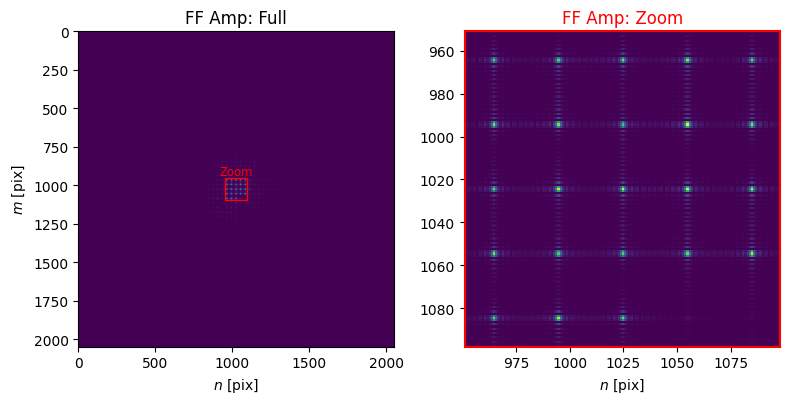

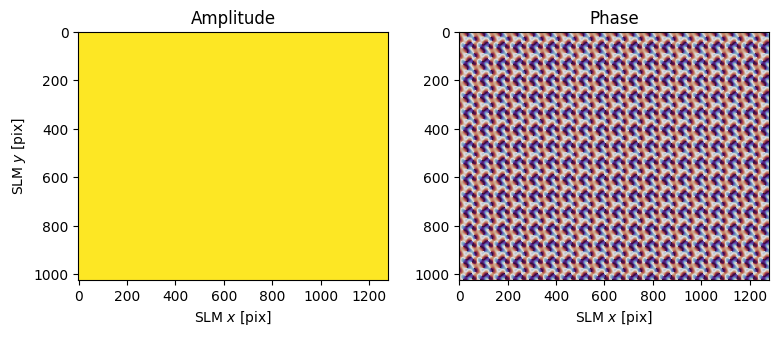

Image grabbed in attempts: 15


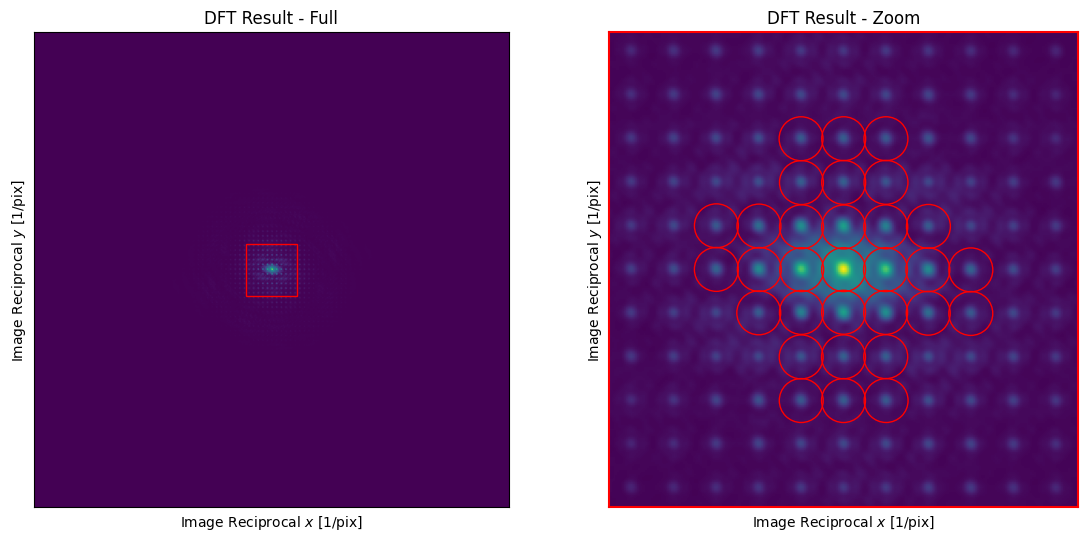

c:\Users\NaCs 2.0\miniconda3\envs\vincentenv\Lib\site-packages\slmsuite\holography\analysis.py:1496: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=4.0)


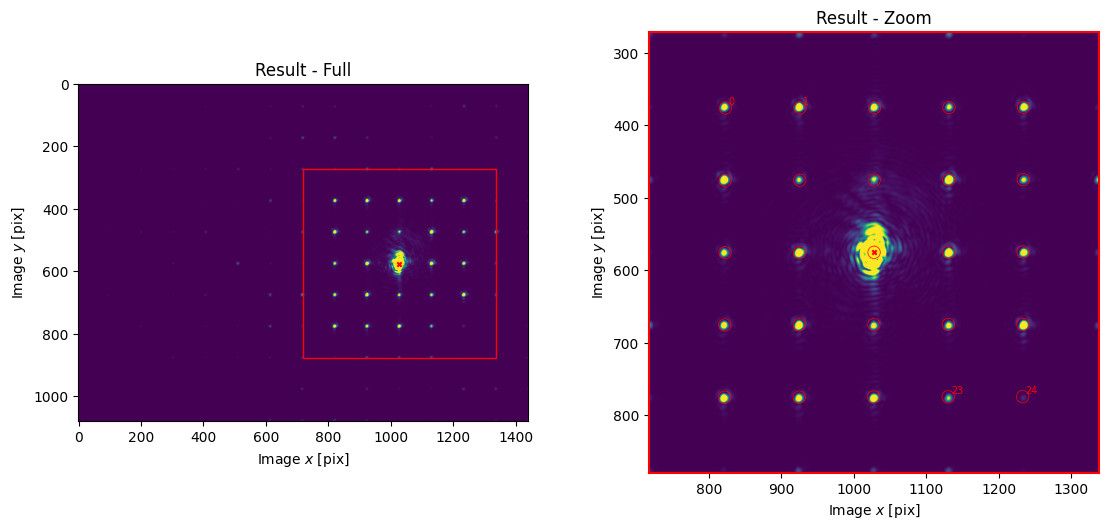

{'M': array([[11911.83548033,   -33.27716832],
        [  -25.97754717, 11564.52211682]]),
 'b': array([[1027.69187836],
        [ 575.44101044]]),
 'a': array([[-8.26058798e-20],
        [ 3.30423519e-19]])}

In [7]:
# Perform Fourier Calibration

# This exposure has been working thus far
cam.set_exposure(0.05)

fs.fourier_calibrate(array_shape=[5, 5], array_pitch=[30, 30], plot=True)

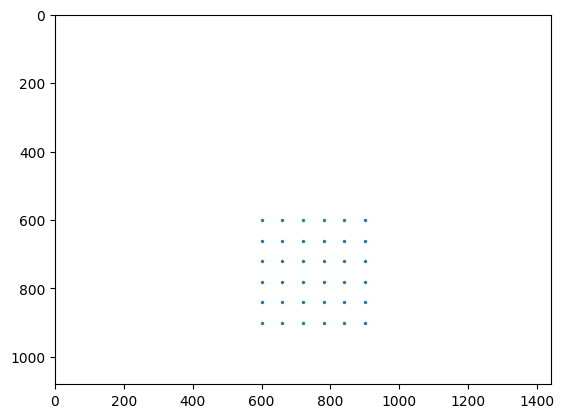

[600 660 720 780 840 900]
[600 660 720 780 840 900]


In [8]:
# Create a 6 x 6 array

pitch = 60 # pixels

# List of x coords
xlist = np.arange(600, 960, pitch)
# List of y coords
ylist = np.arange(600, 960, pitch)

# 2D np array of x and y coords
xgrid, ygrid = np.meshgrid(xlist, ylist)
square = np.vstack((xgrid.ravel(), ygrid.ravel()))

# Plot the array
plt.scatter(square[0, :], square[1, :], s=2)
plt.xlim([0, fs.cam.shape[1]]); plt.ylim([fs.cam.shape[0], 0])
plt.show()

# Print spot coordinates
print(xlist)
print(ylist)

In [9]:
# Create the hologram
from slmsuite.holography.algorithms import SpotHologram
hologram = SpotHologram(shape=(2048, 2048), spot_vectors=square, basis='ij', cameraslm=fs)

# Calculate base phase pattern computationally
hologram.optimize(
    'WGS-Kim',
    maxiter=70,
    feedback='computational_spot',
    stat_groups=['computational_spot']
)


100%|██████████| 70/70 [01:29<00:00,  1.28s/it]


In [10]:
# Hone the result with experimental feedback.

# Use the same exposure as the loss function below
# 13ms has been working thus far
cam.set_exposure(0.013)

hologram.optimize(
    'WGS-Kim',
    maxiter=70,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'],
    fixed_phase=False
)

  0%|          | 0/70 [00:00<?, ?it/s]

Image grabbed in attempts: 1


  1%|▏         | 1/70 [00:01<01:35,  1.38s/it]

Image grabbed in attempts: 1


  3%|▎         | 2/70 [00:03<01:55,  1.70s/it]

Image grabbed in attempts: 1


  4%|▍         | 3/70 [00:04<01:45,  1.58s/it]

Image grabbed in attempts: 1


  6%|▌         | 4/70 [00:06<01:46,  1.61s/it]

Image grabbed in attempts: 1


  7%|▋         | 5/70 [00:08<01:53,  1.75s/it]

Image grabbed in attempts: 1


  9%|▊         | 6/70 [00:09<01:44,  1.64s/it]

Image grabbed in attempts: 1


 10%|█         | 7/70 [00:11<01:43,  1.64s/it]

Image grabbed in attempts: 1


 11%|█▏        | 8/70 [00:12<01:37,  1.58s/it]

Image grabbed in attempts: 1


 13%|█▎        | 9/70 [00:14<01:37,  1.60s/it]

Image grabbed in attempts: 1


 14%|█▍        | 10/70 [00:16<01:44,  1.74s/it]

Image grabbed in attempts: 1


 16%|█▌        | 11/70 [00:18<01:46,  1.80s/it]

Image grabbed in attempts: 1


 17%|█▋        | 12/70 [00:20<01:49,  1.88s/it]

Image grabbed in attempts: 1


 19%|█▊        | 13/70 [00:22<01:49,  1.92s/it]

Image grabbed in attempts: 1


 20%|██        | 14/70 [00:24<01:49,  1.96s/it]

Image grabbed in attempts: 1


 21%|██▏       | 15/70 [00:26<01:39,  1.81s/it]

Image grabbed in attempts: 1


 23%|██▎       | 16/70 [00:27<01:32,  1.72s/it]

Image grabbed in attempts: 1


 24%|██▍       | 17/70 [00:29<01:26,  1.64s/it]

Image grabbed in attempts: 1


 26%|██▌       | 18/70 [00:30<01:25,  1.64s/it]

Image grabbed in attempts: 1


 27%|██▋       | 19/70 [00:32<01:28,  1.74s/it]

Image grabbed in attempts: 1


 29%|██▊       | 20/70 [00:34<01:22,  1.66s/it]

Image grabbed in attempts: 1


 30%|███       | 21/70 [00:35<01:20,  1.65s/it]

Image grabbed in attempts: 1


 31%|███▏      | 22/70 [00:37<01:16,  1.60s/it]

Image grabbed in attempts: 1


 33%|███▎      | 23/70 [00:38<01:15,  1.61s/it]

Image grabbed in attempts: 1


 34%|███▍      | 24/70 [00:40<01:19,  1.72s/it]

Image grabbed in attempts: 1


 36%|███▌      | 25/70 [00:42<01:21,  1.82s/it]

Image grabbed in attempts: 1


 37%|███▋      | 26/70 [00:44<01:22,  1.87s/it]

Image grabbed in attempts: 1


 39%|███▊      | 27/70 [00:46<01:21,  1.90s/it]

Image grabbed in attempts: 1


 40%|████      | 28/70 [00:48<01:21,  1.94s/it]

Image grabbed in attempts: 1


 41%|████▏     | 29/70 [00:50<01:20,  1.97s/it]

Image grabbed in attempts: 1


 43%|████▎     | 30/70 [00:52<01:12,  1.81s/it]

Image grabbed in attempts: 1


 44%|████▍     | 31/70 [00:54<01:08,  1.75s/it]

Image grabbed in attempts: 1


 46%|████▌     | 32/70 [00:55<01:03,  1.67s/it]

Image grabbed in attempts: 1


 47%|████▋     | 33/70 [00:57<01:00,  1.63s/it]

Image grabbed in attempts: 1


 49%|████▊     | 34/70 [00:58<00:56,  1.58s/it]

Image grabbed in attempts: 1


 50%|█████     | 35/70 [01:00<00:56,  1.61s/it]

Image grabbed in attempts: 1


 51%|█████▏    | 36/70 [01:02<00:59,  1.75s/it]

Image grabbed in attempts: 1


 53%|█████▎    | 37/70 [01:04<01:00,  1.84s/it]

Image grabbed in attempts: 1


 54%|█████▍    | 38/70 [01:05<00:55,  1.73s/it]

Image grabbed in attempts: 1


 56%|█████▌    | 39/70 [01:07<00:51,  1.67s/it]

Image grabbed in attempts: 1


 57%|█████▋    | 40/70 [01:08<00:48,  1.62s/it]

Image grabbed in attempts: 1


 59%|█████▊    | 41/70 [01:10<00:46,  1.60s/it]

Image grabbed in attempts: 1


 60%|██████    | 42/70 [01:12<00:48,  1.74s/it]

Image grabbed in attempts: 1


 61%|██████▏   | 43/70 [01:13<00:44,  1.65s/it]

Image grabbed in attempts: 1


 63%|██████▎   | 44/70 [01:15<00:42,  1.65s/it]

Image grabbed in attempts: 1


 64%|██████▍   | 45/70 [01:16<00:39,  1.59s/it]

Image grabbed in attempts: 1


 66%|██████▌   | 46/70 [01:18<00:38,  1.59s/it]

Image grabbed in attempts: 1


 67%|██████▋   | 47/70 [01:20<00:39,  1.70s/it]

Image grabbed in attempts: 1


 69%|██████▊   | 48/70 [01:22<00:36,  1.64s/it]

Image grabbed in attempts: 1


 70%|███████   | 49/70 [01:23<00:34,  1.62s/it]

Image grabbed in attempts: 1


 71%|███████▏  | 50/70 [01:25<00:31,  1.58s/it]

Image grabbed in attempts: 1


 73%|███████▎  | 51/70 [01:26<00:29,  1.57s/it]

Image grabbed in attempts: 1


 74%|███████▍  | 52/70 [01:28<00:27,  1.54s/it]

Image grabbed in attempts: 1


 76%|███████▌  | 53/70 [01:29<00:27,  1.59s/it]

Image grabbed in attempts: 1


 77%|███████▋  | 54/70 [01:31<00:27,  1.70s/it]

Image grabbed in attempts: 1


 79%|███████▊  | 55/70 [01:33<00:26,  1.80s/it]

Image grabbed in attempts: 1


 80%|████████  | 56/70 [01:35<00:26,  1.87s/it]

Image grabbed in attempts: 1


 81%|████████▏ | 57/70 [01:37<00:22,  1.76s/it]

Image grabbed in attempts: 1


 83%|████████▎ | 58/70 [01:38<00:20,  1.72s/it]

Image grabbed in attempts: 1


 84%|████████▍ | 59/70 [01:40<00:18,  1.64s/it]

Image grabbed in attempts: 1


 86%|████████▌ | 60/70 [01:42<00:16,  1.67s/it]

Image grabbed in attempts: 1


 87%|████████▋ | 61/70 [01:44<00:16,  1.82s/it]

Image grabbed in attempts: 1


 89%|████████▊ | 62/70 [01:45<00:13,  1.69s/it]

Image grabbed in attempts: 1


 90%|█████████ | 63/70 [01:47<00:11,  1.67s/it]

Image grabbed in attempts: 1


 91%|█████████▏| 64/70 [01:48<00:09,  1.60s/it]

Image grabbed in attempts: 1


 93%|█████████▎| 65/70 [01:50<00:08,  1.61s/it]

Image grabbed in attempts: 1


 94%|█████████▍| 66/70 [01:51<00:06,  1.57s/it]

Image grabbed in attempts: 1


 96%|█████████▌| 67/70 [01:53<00:04,  1.55s/it]

Image grabbed in attempts: 1


 97%|█████████▋| 68/70 [01:54<00:03,  1.53s/it]

Image grabbed in attempts: 1


 99%|█████████▊| 69/70 [01:56<00:01,  1.59s/it]

Image grabbed in attempts: 1


100%|██████████| 70/70 [01:58<00:00,  1.69s/it]


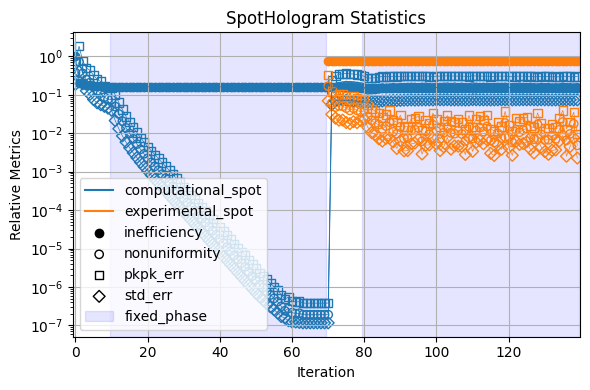

<Axes: title={'center': 'SpotHologram Statistics'}, xlabel='Iteration', ylabel='Relative Metrics'>

In [11]:
# Plot calculation statistics
hologram.plot_stats()

Image grabbed in attempts: 1


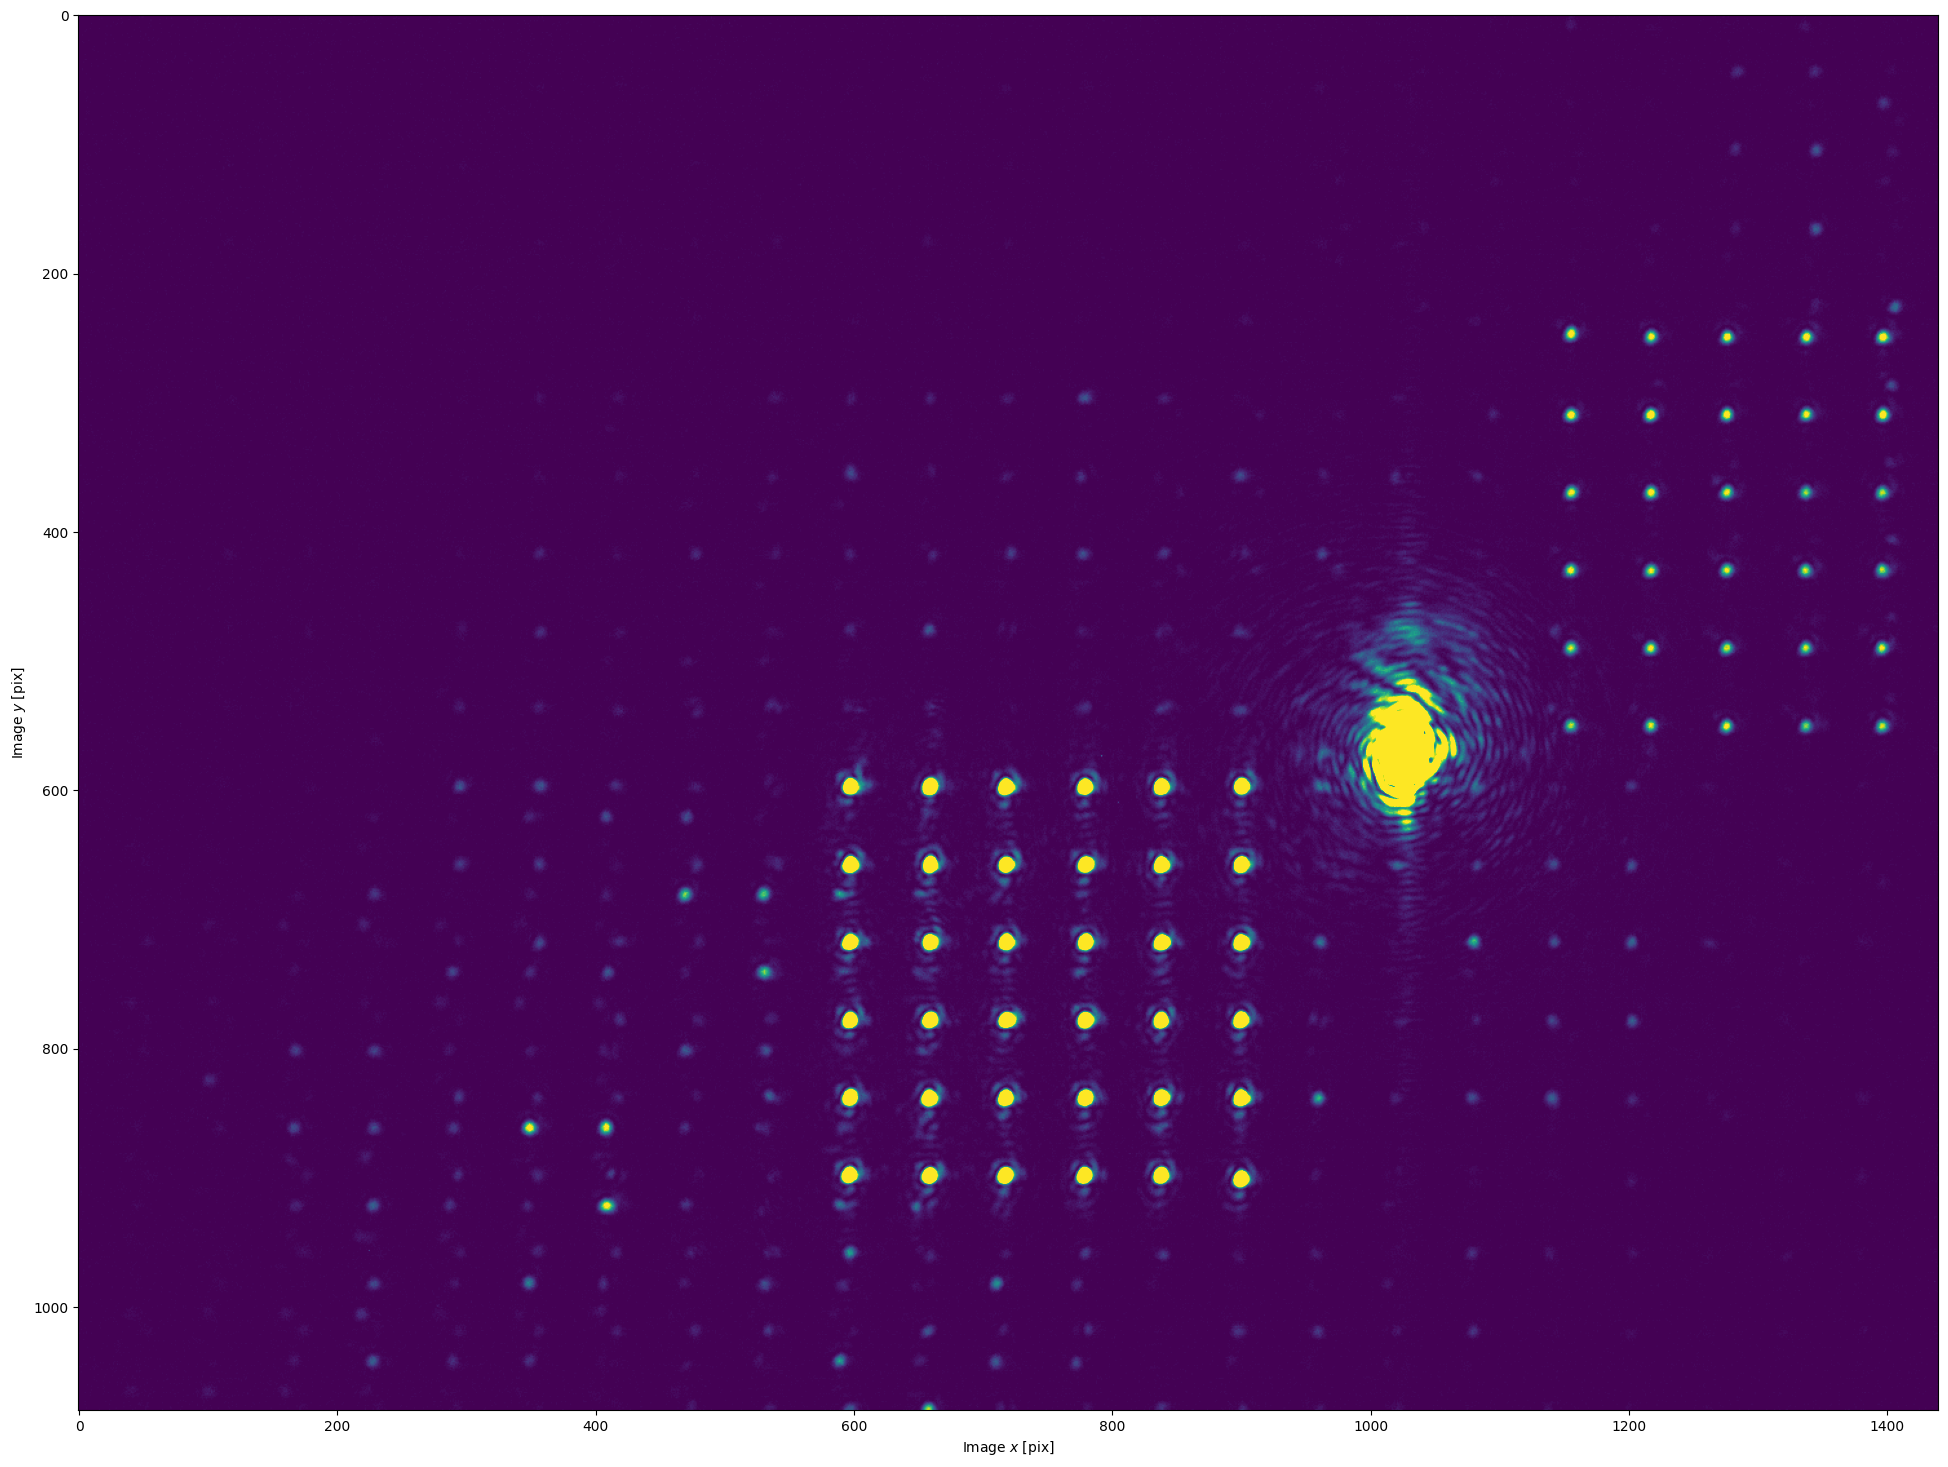

In [12]:
# Extract base phase pattern
base = hologram.extract_phase()

# Write onto the SLM
slm.write(phase=base, settle=True)

# Get and display camera image of the array
cam.set_exposure(.013) 
img = cam.get_image()                                

plt.figure(figsize=(24,24));    plt.imshow(img, vmax=50)   
plt.xlabel("Image $x$ [pix]");  plt.ylabel("Image $y$ [pix]")
plt.show()

In [22]:
# Loss function for Nelder-Mead Search

# Input is a point corresponding to the coefficients of each Zernike in the linear combination
def loss_function(p, plot=False):
    
    # Get the linear combination of zernikes
    zernike_sum_phase = toolbox.phase.zernike_sum(
        grid=slm,
        weights=(
            ((0, 0),  p[0]),                                   
            ((1, 1),  p[1]),
            ((1, 0),  p[2]),
            ((2, 2),  p[3]),
            ((2, 1),  p[4]),
            ((2, 0),  p[5]),
            ((3, 3),  p[6]),
            ((3, 2),  p[7]),
            ((3, 1),  p[8]),
            ((3, 0),  p[9])
        ),
        aperture="circular"
    )

    # Add the zernike to the base
    phase = base + zernike_sum_phase
    
    # Write the phase to the SLM
    slm.write(phase, settle=True)

    # Take a camera image
    # Exposure of 13ms has been working thus far to avoid oversaturation
    cam.set_exposure(.013)
    img = cam.get_image()                                        
    
    # Fit the entire array to a 2D Gaussian
    popt_arrays, r_squared_values, waist_residuals = fit_array(box_size=60, shiftx=0, shifty=0, img=img / 1024, hologram=hologram, plot=plot)

    # Extract the fit statistics
    wxs, wys, a_arr = fit_stats(popt_arrays, plot=plot)

    # Calculate the loss value
    loss = -np.mean(r_squared_values) + 10 * np.std(a_arr) / np.mean(a_arr)
    
    if plot is True:
        print(np.sum(r_squared_values))
        print(np.sum(waist_residuals))
        print(np.std(wxs))
        print(np.std(wys))
        print(np.std(a_arr))
        
    return loss

In [25]:
initial_point = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
initial_step = 3.5
maxiter = 100
alpha = 1
gamma = 2
rho = 0.5
sigma = 0.5
final_simplex = nelder_mead(loss_function, initial_point, initial_step, 1, maxiter, alpha, gamma, rho, sigma)

Image grabbed in attempts: 1
Image grabbed in attempts: 1
Image grabbed in attempts: 1
Image grabbed in attempts: 1
Image grabbed in attempts: 1
Image grabbed in attempts: 1
Image grabbed in attempts: 1
Image grabbed in attempts: 1
Image grabbed in attempts: 1
Image grabbed in attempts: 1
Image grabbed in attempts: 1
[[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), -0.21016436326332522], [array([3.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]), 4.843740530916072], [array([0. , 3.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]), 0.5309671317108944], [array([0. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ]), 4.585439167888727], [array([0. , 0. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. , 0. ]), 6.731495581271226], [array([0. , 0. , 0. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. ]), 5.464167766255276], [array([0. , 0. , 0. , 0. , 0. , 3.5, 0. , 0. , 0. , 0. ]), 10.518886421935546], [array([0. , 0. , 0. , 0. , 0. , 0. , 3.5, 0. , 0. , 0. ]), 6.671689226774188], [array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 3.

KeyboardInterrupt: 

In [ ]:
# NO ZERNIKES

# Fit the array and plot fit + histograms
p = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
loss_function(p, plot=True)

In [ ]:
# WITH ZERNIKES

final_point = final_simplex[0][0]
#final_point = np.array([0.5677004, 1.08640392, -0.86870066, 0.12773411, 0.39490835, 0.61080827, 0.46329439, -1.15338756, 0.478536, 1.04677298])
loss_function(final_point, plot=True)